# Code for Interactive Map and Profiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from shapely.geometry import Point, Polygon
import folium
from folium import Element
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from base64 import b64encode
import glob
from rasterio.plot import show
import rasterio
from matplotlib.ticker import ScalarFormatter
import cmocean
import geopandas as gpd

## Processing all the data from total_df.ipynb 

In [2]:
# read in all casts processed in total_df.ipynb
total_df = pd.read_csv('../../data/total_df.csv')

# display the first 5 rows of the df 
total_df.head()

,Unnamed: 0.1,Unnamed: 0,Pressure (dbar),Depth (m),Temperature (°C),Conductivity (µS/cm),Specific Conductance (µS/cm),Salinity (PSS),Sound Velocity (m/s),Density (kg/m³),Latitude,Longitude,UTC Time,File Name,Area,TestType
0,0,0,0.15,0.153151,9.153524,296.339874,433.834991,0.204679,1444.146359,999.934361,40.274148,-106.8399,2025-05-13 18:12:11,CC2435009_20250513_181211,MOR,cast
1,1,1,0.45,0.458792,9.255136,295.835466,431.811837,0.203774,1444.561198,999.927172,40.274148,-106.8399,2025-05-13 18:12:11,CC2435009_20250513_181211,MOR,cast
2,2,2,0.75,0.764653,9.132318,295.647002,433.089545,0.204300,1444.069489,999.938574,40.274148,-106.8399,2025-05-13 18:12:11,CC2435009_20250513_181211,MOR,cast
3,3,3,1.05,1.070511,9.033097,296.121842,435.049797,0.205173,1443.672646,999.948268,40.274148,-106.8399,2025-05-13 18:12:11,CC2435009_20250513_181211,MOR,cast
4,4,4,1.35,1.376366,8.925369,296.570547,437.092585,0.206079,1443.240202,999.958485,40.274148,-106.8399,2025-05-13 18:12:11,CC2435009_20250513_181211,MOR,cast


In [4]:
# Extract the first row for each cast (based on File Name)
cast_locations = total_df.groupby("File Name").first().reset_index()

# Optional: if you want only lat/lon and filename
cast_locations = cast_locations[["Latitude", "Longitude", "File Name"]]

## Creating the profiles 

In [6]:
output_dir = "profiles"
os.makedirs(output_dir, exist_ok=True)

grouped_meas = total_df.groupby('File Name')

# We'll collect all data into a list of dicts
image_data = []

for date, group in grouped_meas:
    group = group.sort_values(by='Depth (m)') 

    # Determine test type based on number of depth values
    test_type = "point" if group['Depth (m)'].nunique() <= 1 else "cast"

    if test_type == "cast":
        fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
        fig.suptitle(f'Profiles on {date}', fontsize=36)

        axs[0].plot(group['Temperature (°C)'], group['Depth (m)'])
        axs[0].set_xlabel('Temperature (°C)', fontsize=24, fontweight='bold')
        axs[0].set_ylabel('Depth (m)', fontsize=24, fontweight='bold')
        axs[0].invert_yaxis()

        axs[1].plot(group['Conductivity (µS/cm)'], group['Depth (m)'])
        axs[1].set_xlabel('Conductivity (µS/cm)', fontsize=24, fontweight='bold')

        axs[2].plot(group['Salinity (PSS)'], group['Depth (m)'])
        axs[2].set_xlabel('Salinity (PSS)', fontsize=24, fontweight='bold')

        axs[3].plot(group['Density (kg/m³)'], group['Depth (m)'])
        axs[3].set_xlabel('Density (kg/m³)', fontsize=24, fontweight='bold')

        for ax in axs:
            ax.tick_params(axis='both', labelsize=16)

        plt.tight_layout()

        img_path = os.path.join(output_dir, f"profile_{date}.png")
        fig.savefig(img_path)
        plt.close(fig)
    else:
        img_path = None  # No image for point measurement

    # Store info
    image_data.append({
        'File Name': date,
        'Latitude': group.iloc[0]['Latitude'],
        'Longitude': group.iloc[0]['Longitude'],
        'ImagePath': img_path,
        'TestType': test_type,
        'Temperature (°C)': group['Temperature (°C)'].iloc[0],
        'Conductivity (µS/cm)': group['Conductivity (µS/cm)'].iloc[0],
        'Salinity (PSS)': group['Salinity (PSS)'].iloc[0],
        'Density (kg/m³)': group['Density (kg/m³)'].iloc[0],
    })


In [7]:
# Create DataFrame
image_df = pd.DataFrame(image_data)
image_df.head()

,File Name,Latitude,Longitude,ImagePath,TestType,Temperature (°C),Conductivity (µS/cm),Salinity (PSS),Density (kg/m³)
0,CC2435009_20250513_181211,40.274148,-106.839900,profiles\profile_CC2435009_20250513_181211.png,cast,9.153524,296.339874,0.204679,999.934361
1,CC2435009_20250513_181617,40.276507,-106.841752,profiles\profile_CC2435009_20250513_181617.png,cast,9.902309,302.497925,0.204992,999.873001
2,CC2435009_20250513_182530,40.279905,-106.851733,profiles\profile_CC2435009_20250513_182530.png,cast,12.425925,324.117126,0.206352,999.611949
3,CC2435009_20250513_182851,40.279532,-106.852019,profiles\profile_CC2435009_20250513_182851.png,cast,12.494535,324.762451,0.206421,999.603737
4,CC2435009_20250513_194404,40.283628,-106.853450,profiles\profile_CC2435009_20250513_194404.png,cast,12.716255,327.775024,0.207239,999.577265


In [8]:
# Merge 'TestType' from cast_locations into total_df based on 'File Name'
cast_locations['TestType'] = image_df['TestType']
cast_locations['ImagePath'] = image_df['ImagePath']
total_df = total_df.merge(cast_locations[['File Name', 'TestType']], on='File Name', how='left')    
total_df = total_df.merge(cast_locations[['File Name', 'ImagePath']], on='File Name', how='left') 
total_df.to_csv('total_df')

## Setting up the interactive map using Folium

In [9]:
# ---- Define Polygons ----
polygon_coords = {
    'DOC': [(40.28429, -106.85365), (40.28360, -106.85341), (40.28240, -106.85488), (40.28356, -106.85524)],
    'HAR': [(40.28424, -106.85348), (40.28565, -106.85185), (40.28797, -106.85680), (40.28793, -106.85836)],
    'MOR': [(40.28003, -106.84560), (40.28021, -106.84274), (40.27252, -106.83760), (40.27183, -106.84056)],
    'GLZ': [(40.27291, -106.84515), (40.27610, -106.85043), (40.27509, -106.85397), (40.27129, -106.84970)],
    'KEY': [(40.27705, -106.86361), (40.27700, -106.86697), (40.28124, -106.86839), (40.28180, -106.86597)],
    'LIL': [(40.27265, -106.86163), (40.27315, -106.85961), (40.27114, -106.85906), (40.27115, -106.86068)],
    'ASP': [(40.272286, -106.876870),(40.272286, -106.876599),(40.272016, -106.876599),(40.272016, -106.876870)]
}
polygons = {name: Polygon(coords) for name, coords in polygon_coords.items()}

# ---- Classify Points by Area ----
def get_area(lat, lon):
    point = Point(lat, lon)
    for name, poly in polygons.items():
        if poly.contains(point):
            return name
    return 'MID'

# ---- Process Data ----
cast_locations['Area'] = cast_locations.apply(lambda row: get_area(row['Latitude'], row['Longitude']), axis=1)
total_df['Area'] = total_df.apply(lambda row: get_area(row['Latitude'], row['Longitude']), axis=1)
cast_locations['Date'] = pd.to_datetime(cast_locations['File Name'].str.extract(r'_(\d{8})_')[0], format='%Y%m%d')

In [10]:
# ---- Color Map for Areas ----
area_colors = {
    'DOC': 'red',
    'HAR': 'cyan',
    'MOR': 'purple',
    'GLZ': 'orange',
    'KEY': 'darkblue',
    'LIL': 'darkred',
    'ASP': 'pink',
    'MID': 'gray'
}

# ---- Legend HTML ----
legend_html = """
<div style="
    position: fixed; 
    bottom: 30px; left: 30px; width: 150px; z-index:500;
    background-color: white; padding: 10px; border: 2px solid grey;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3); font-size:14px;">
<b>Areas</b><br>
<i style='background:red; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Dock<br>
<i style='background:cyan; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Harding Cove<br>
<i style='background:purple; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Morrison Cove<br>
<i style='background:orange; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Glizzy Cove<br>
<i style='background:darkblue; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Keystone Cove<br>
<i style='background:darkred; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Small Inlet<br>
<i style='background:pink; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Aspen View<br>
<i style='background:gray; width:10px; height:10px; float:left; margin-right:8px; display:inline-block'></i>Middle of Reservoir
</div>
"""

# ---- Widget Setup ----
date_picker = widgets.DatePicker(description='Pick a date', value=cast_locations['Date'].min())
toggle_button = widgets.ToggleButton(value=False, description="Show All Data", button_style='info')
save_button = widgets
map_output = widgets.Output()

def update_map(change=None):
    with map_output:
        clear_output(wait=True)
        if toggle_button.value:
            filtered = cast_locations
        else:
            selected_date = date_picker.value
            filtered = cast_locations[cast_locations['Date'] == pd.to_datetime(selected_date)]
        
        # Create map
        m = folium.Map(
            location=[filtered["Latitude"].mean(), filtered["Longitude"].mean()],
            zoom_start=13
        )

        # ---- Plot Polygons ----
#        for name, coords in polygon_coords.items():
#            folium.Polygon(
#                locations=coords,
#                color=area_colors[name],
#                fill=True,
#                fill_opacity=0.15,
#                popup=f"{name} Area"
#            ).add_to(m)
        
        # Plot points
        for _, row in filtered.iterrows():

            if row['TestType'] == 'point':
                # Show raw measurement values
                point = total_df[total_df['File Name'] == row['File Name']]
                popup_html = f"""
                <b>File:</b> {row['File Name']}<br>
                <b>Test Type:</b> {'Point'}<br>
                <b>Lat:</b> {row['Latitude']}<br>
                <b>Lon:</b> {row['Longitude']}<br>
                <b>Area:</b> {row['Area']}<br>
                <b>Temperature (°C):</b> {point['Temperature (°C)'].iloc[0]}<br>
                <b>Conductivity (µS/cm):</b> {point['Conductivity (µS/cm)'].iloc[0]}<br>
                <b>Salinity (PSS):</b> {point['Salinity (PSS)'].iloc[0]}<br>
                <b>Density (kg/m³):</b> {point['Density (kg/m³)'].iloc[0]}<br>
                """
                iframe = folium.IFrame(popup_html, width=300, height=250)
                popup = folium.Popup(iframe, max_width=300)   

            elif row['TestType'] == 'cast':
                with open(row['ImagePath'], 'rb') as f:
                    encoded = b64encode(f.read()).decode()
                popup_html = f"""
                    <div>
                        <a href="data:image/png;base64,{encoded}" target="_blank">
                            <img src="data:image/png;base64,{encoded}" width="700">
                        </a><br>
                        <b>Date:</b> {row['Date'].date()}<br>
                        <b>Test Type:</b> {'Cast'}<br>
                        <b>File:</b> {row['File Name']}<br>
                        <b>Lat:</b> {row['Latitude']}<br>
                        <b>Lon:</b> {row['Longitude']}<br>
                        <b>Area:</b> {row['Area']}
                    </div>
                """
                iframe = folium.IFrame(html=popup_html, width=450, height=300)
                popup = folium.Popup(iframe, max_width=450)    
            
            folium.CircleMarker(
                location=[row["Latitude"], row["Longitude"]],
                radius=5,
                popup = popup,
                color=area_colors.get(row["Area"], "gray"),
                fill=True,
                fill_color=area_colors.get(row["Area"], "gray"),
                fill_opacity=0.9
            ).add_to(m)

        m.get_root().html.add_child(Element(legend_html))
        display(m)
        m.save("map.html")

# ---- Connect Handlers ----
date_picker.observe(update_map, names='value')
toggle_button.observe(update_map, names='value')

# ---- Show UI ----
display(widgets.HBox([date_picker, toggle_button]))
display(map_output)
update_map()  # Initial call




Output()

## Looking at the profiles of Harding and Keystone Coves on 05-17 and 05-18 and comparing these to Dock measurements

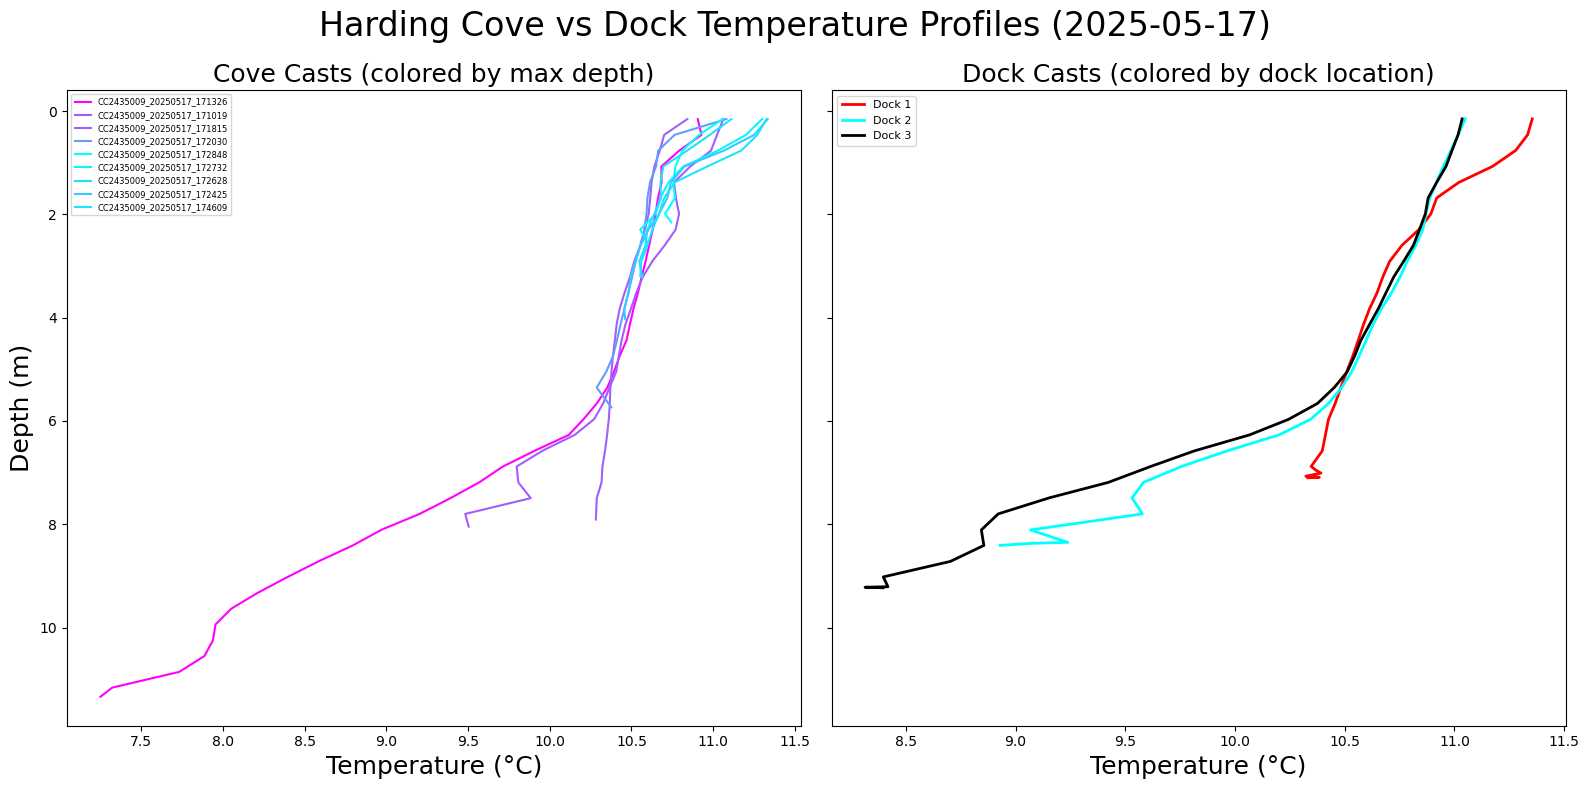

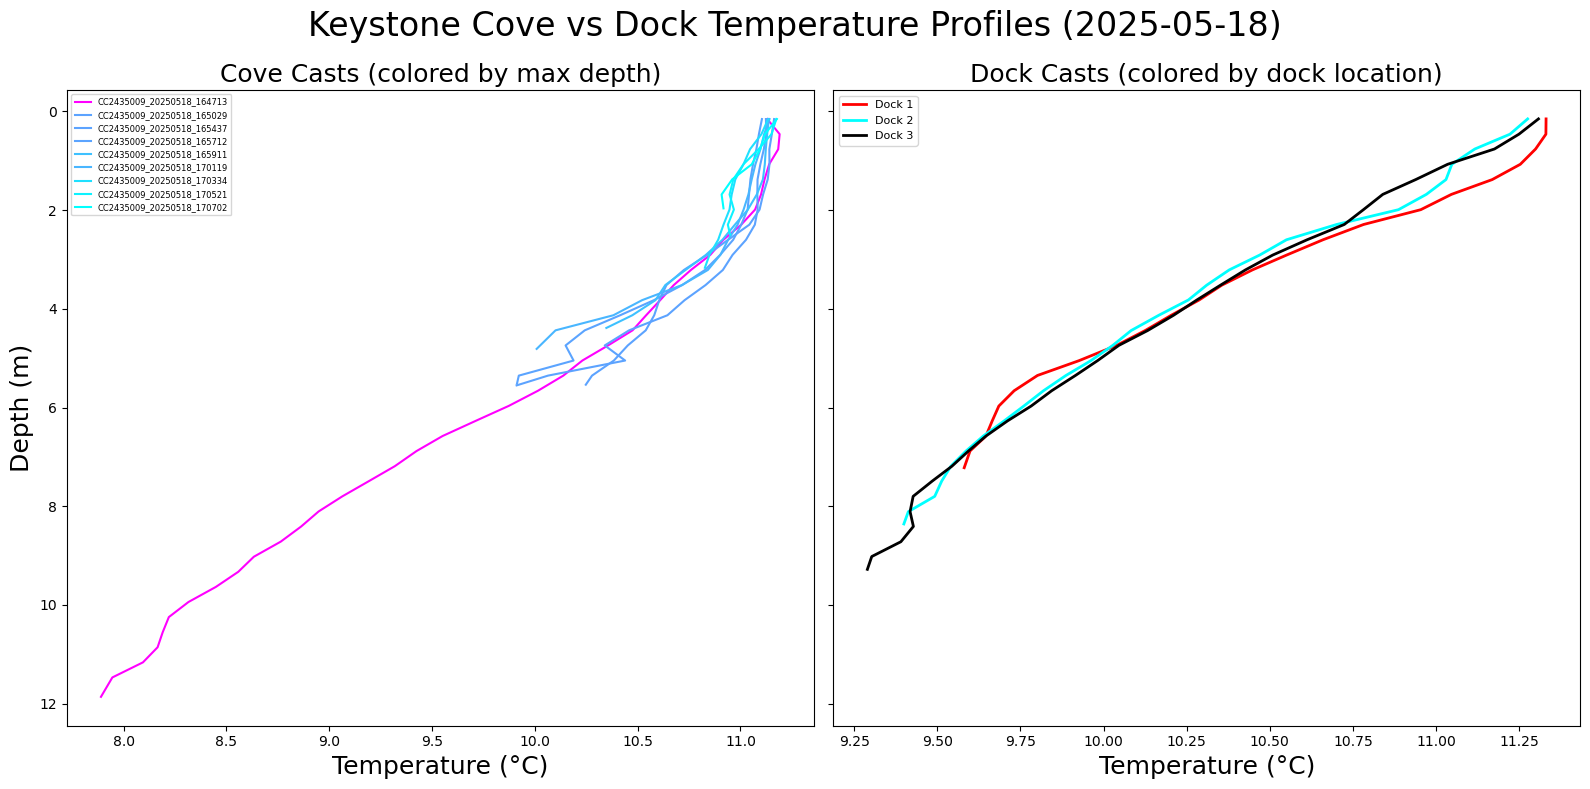

In [12]:
# time for some temperature profiles

# Harding file names for cove casts and dock casts 
harding_fnames = ['CC2435009_20250517_171326', 'CC2435009_20250517_171019', 'CC2435009_20250517_171815', 'CC2435009_20250517_172030', 
                  'CC2435009_20250517_172848', 'CC2435009_20250517_172732', 'CC2435009_20250517_172628', 'CC2435009_20250517_172425', 
                  'CC2435009_20250517_174609']
harding_dock1 = ['CC2435009_20250517_175733', 'CC2435009_20250517_175849', 'CC2435009_20250517_175943', 'CC2435009_20250517_180034', 'CC2435009_20250517_180205', 'CC2435009_20250517_180242']

harding_dock2 = ['CC2435009_20250517_180414', 'CC2435009_20250517_180453', 'CC2435009_20250517_180530']

harding_dock3 = ['CC2435009_20250517_180717', 'CC2435009_20250517_180756', 'CC2435009_20250517_180836']

# Keystone file names for cove casts and dock casts 
keystone_fnames = ['CC2435009_20250518_164713', 'CC2435009_20250518_165029', 'CC2435009_20250518_165437', 'CC2435009_20250518_165712',
                   'CC2435009_20250518_165911', 'CC2435009_20250518_170119', 'CC2435009_20250518_170334', 'CC2435009_20250518_170521',
                   'CC2435009_20250518_170702']
keystone_dock1 = ['CC2435009_20250518_183359']
keystone_dock2 = ['CC2435009_20250518_184039']
keystone_dock3 = ['CC2435009_20250518_184557']

import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_temperature_profiles(cove_files, dock_dict, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    fig.suptitle(title, fontsize=24)

    # --- Cove Casts: colored by max depth ---
    cmap = cm.cool
    depths = []

    for fname in cove_files:
        cast = total_df[total_df['File Name'] == fname].sort_values('Depth (m)')
        max_depth = cast['Depth (m)'].max()
        depths.append(max_depth)

    norm = mcolors.Normalize(vmin=min(depths), vmax=max(depths))

    for fname in cove_files:
        cast = total_df[total_df['File Name'] == fname].sort_values('Depth (m)', ascending=False)
        max_depth = cast['Depth (m)'].max()
        color = cmap(norm(max_depth))
        axs[0].plot(cast['Temperature (°C)'], cast['Depth (m)'], label=f"{fname}", color=color)

    
    axs[0].set_title('Cove Casts (colored by max depth)', fontsize=18)
    axs[0].set_xlabel('Temperature (°C)', fontsize=18)
    axs[0].set_ylabel('Depth (m)', fontsize=18)
    axs[0].invert_yaxis()
    axs[0].legend(fontsize=6)

    # --- Dock Casts: colored by location ---
    dock_colors = {
        'Dock 1': 'red',
        'Dock 2': 'cyan',
        'Dock 3': 'black'
    }

    for dock_label, file_list in dock_dict.items():
        # Combine all casts for this dock
        dock_df = total_df[total_df['File Name'].isin(file_list)].copy()
    
        # Round or bin depth to a standard set (if needed)
        dock_df['Depth (m)'] = dock_df['Depth (m)'].round(2)  # You can bin instead if needed
    
        # Group by depth and average
        avg_cast = dock_df.groupby('Depth (m)', as_index=False)['Temperature (°C)'].mean()
        avg_cast = avg_cast.sort_values('Depth (m)')

        # Plot averaged profile
        axs[1].plot(
            avg_cast['Temperature (°C)'], avg_cast['Depth (m)'],
            label=dock_label,
            color=dock_colors[dock_label],
            linewidth=2)

    
    axs[1].set_title('Dock Casts (colored by dock location)', fontsize=18)
    axs[1].set_xlabel('Temperature (°C)', fontsize=18)
    #axs[1].invert_yaxis()
    axs[1].legend(fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Create dock dicts
harding_dock_dict = {
    'Dock 1': harding_dock1,
    'Dock 2': harding_dock2,
    'Dock 3': harding_dock3
}

keystone_dock_dict = {
    'Dock 1': keystone_dock1,
    'Dock 2': keystone_dock2,
    'Dock 3': keystone_dock3
}

# Plot
plot_temperature_profiles(harding_fnames, harding_dock_dict, 'Harding Cove vs Dock Temperature Profiles (2025-05-17)')
plot_temperature_profiles(keystone_fnames, keystone_dock_dict, 'Keystone Cove vs Dock Temperature Profiles (2025-05-18)')

In [19]:
# Assuming cast_locations has 'Latitude', 'Longitude', 'File Name', and maybe 'Cove' columns
# Filter for Harding Cove and Keystone Cove file names

harding_files = harding_fnames
keystone_files = keystone_fnames
dock_files = harding_dock1 + harding_dock2 + harding_dock3 

harding_points = cast_locations[cast_locations['File Name'].isin(harding_files)]
keystone_points = cast_locations[cast_locations['File Name'].isin(keystone_files)]
dock_points = cast_locations[cast_locations['File Name'].isin(dock_files)]

dock_gdf = gpd.GeoDataFrame(dock_points, 
                            geometry=gpd.points_from_xy(dock_points['Longitude'], dock_points['Latitude']),
                            crs='EPSG:4326')

# Create GeoDataFrames with geometry column
harding_gdf = gpd.GeoDataFrame(
    harding_points,
    geometry=gpd.points_from_xy(harding_points['Longitude'], harding_points['Latitude']),
    crs='EPSG:4326'  # WGS84 lat/lon
)

keystone_gdf = gpd.GeoDataFrame(
    keystone_points,
    geometry=gpd.points_from_xy(keystone_points['Longitude'], keystone_points['Latitude']),
    crs='EPSG:4326'
)


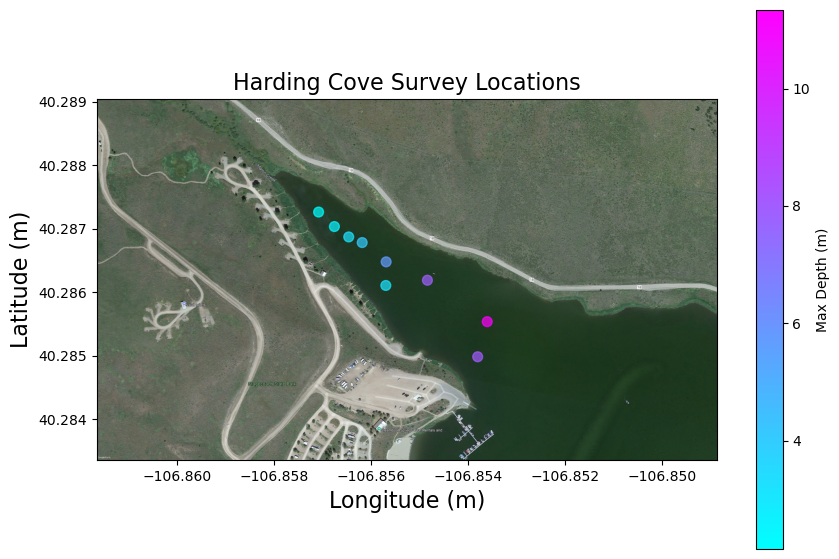

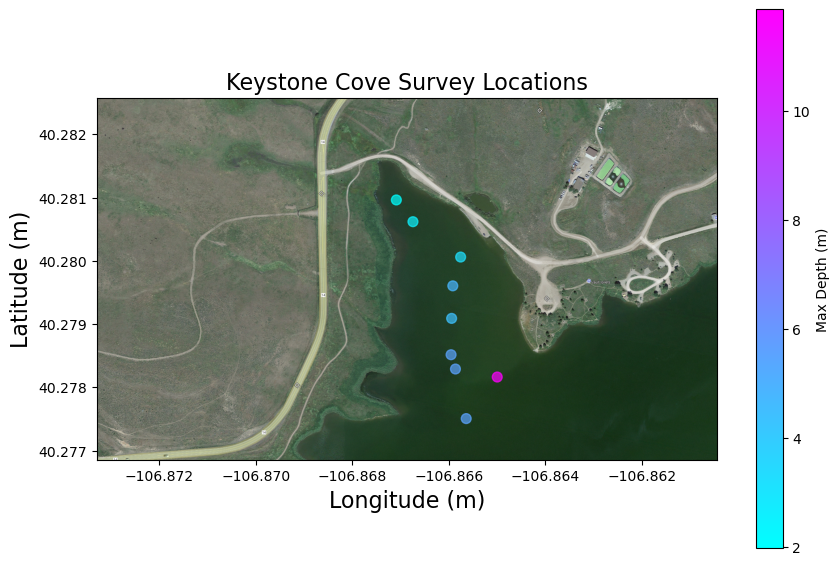

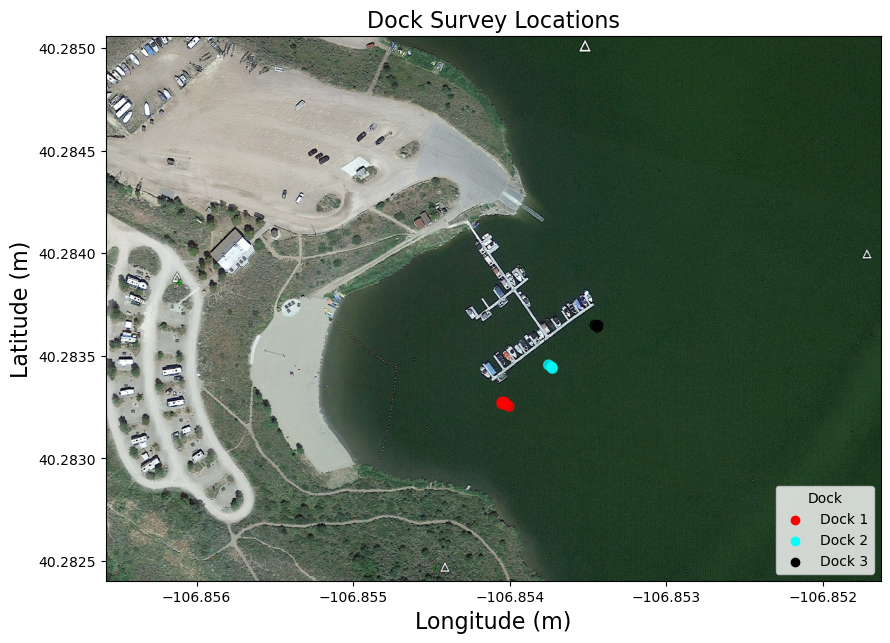

In [20]:
# Combine for lookup
dock1_files = set(harding_dock1)
dock2_files = set(keystone_dock2 + harding_dock2)
dock3_files = set(keystone_dock3 + harding_dock3)

dock_colors = {
    'Dock 1': 'red',
    'Dock 2': 'cyan',
    'Dock 3': 'black'
}


def assign_dock_label(file_name):
    if file_name in dock1_files:
        return 'Dock 1'
    elif file_name in dock2_files:
        return 'Dock 2'
    elif file_name in dock3_files:
        return 'Dock 3'
    else:
        return None

def plot_survey_on_raster(tif_path, gdf_points, title):
    is_dock = 'Dock' in title

    if is_dock:
        # Assign dock label and color
        gdf = gdf_points.copy()
        gdf['Dock'] = gdf['File Name'].apply(assign_dock_label)
        gdf['color'] = gdf['Dock'].map(dock_colors)
    else:
        # Depth-based coloring
        max_depths = (
            total_df.groupby('File Name')['Depth (m)']
            .max()
            .rename('Max Depth')
            .reset_index()
        )
        gdf = gdf_points.merge(max_depths, on='File Name', how='left').copy()
        cmap = cm.cool
        norm = mcolors.Normalize(vmin=gdf['Max Depth'].min(), vmax=gdf['Max Depth'].max())
        gdf['color'] = gdf['Max Depth'].apply(lambda d: cmap(norm(d)))

    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax)

        # Reproject if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Plot
        gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=50, alpha=0.7)

        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Longitude (m)', fontsize=16)
        ax.set_ylabel('Latitude (m)', fontsize=16)
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
        ax.ticklabel_format(style='plain', axis='both')

        if not is_dock:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, ax=ax, label='Max Depth (m)', shrink=0.7)
        else:
            # Optional: add legend
            for dock, color in dock_colors.items():
                ax.scatter([], [], color=color, label=dock)
            ax.legend(title='Dock', loc='lower right')

        plt.show()

# Call the function for each cove
plot_survey_on_raster("../../notebooks/tifs/2good harding cove_modified.tif", harding_gdf, "Harding Cove Survey Locations")
plot_survey_on_raster("../../notebooks/tifs/Keystonetif.tif", keystone_gdf, "Keystone Cove Survey Locations")
plot_survey_on_raster('../../notebooks/tifs/docktif.tif', dock_gdf, 'Dock Survey Locations')


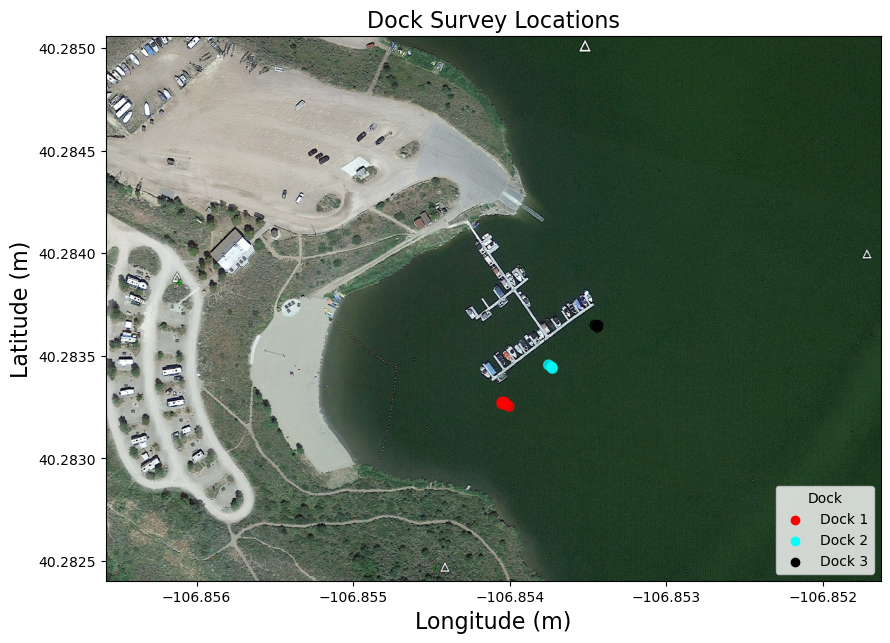